# **Overview**
Pneumonia is an infection in one or both lungs. The infection causes inflammation in the air sacs in your lungs, which are called alveoli. The alveoli fill with fluid or pus, making it difficult to breathe.Pneumonia is a lung infection that can range from mild to so severe that you have to go to the hospital.
![](https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2016/05/18/13/02/ww5r032t-8col-jpg.jpg)

# **Pneumonia Inflammation**

Doctors or radiologiests conduct a physical exam and use CXR(chest x-ray) to examin and detect pneumonia. In CXR it shows opacity in the reagion.

# **Pneumonia Symptoms**

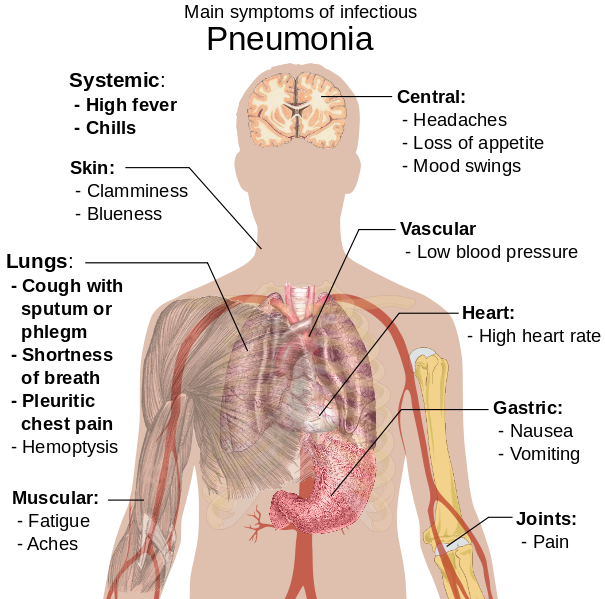

# **How Is Pneumonia Diagnosed?**
Sometimes pneumonia can be difficult to diagnose because the symptoms are so variable, and are often very similar to those seen in a cold or influenza. To diagnose pneumonia, and to try to identify the germ that is causing the illness, your doctor will ask questions about your medical history, do a physical exam, and run some tests.

# **Medical history**
Your doctor will ask you questions about your signs and symptoms, and how and when they began. To help figure out if your infection is caused by bacteria, viruses or fungi, you may be asked some questions about possible exposures, such as:

# **Physical exam**
Your doctor will listen to your lungs with a stethoscope. If you have pneumonia, your lungs may make crackling, bubbling, and rumbling sounds when you inhale.

# **Diagnostic Tests**
If your doctor suspects you may have pneumonia, they will probably recommend some tests to confirm the diagnosis and learn more about your infection. These may include:

1) Blood tests to confirm the infection and to try to identify the germ that is causing your illness.

2) Chest X-ray to look for the location and extent of inflammation in your lungs.

3) Pulse oximetry to measure the oxygen level in your blood. Pneumonia can prevent your lungs from moving enough    oxygen into your bloodstream.

4) Sputum test on a sample of mucus (sputum) taken after a deep cough, to look for the source of the infection.

If you are considered a high-risk patient because of your age and overall health, or if you are hospitalized,    the doctors may want to do some additional tests, including:

5) CT scan of the chest to get a better view of the lungs and look for abscesses or other complications.

6) Arterial blood gas test, to measure the amount of oxygen in a blood sample taken from an artery, usually in      your wrist. This is more accurate than the simpler pulse oximetry.

7) Pleural fluid culture, which removes a small amount of fluid from around tissues that surround the lung, to      analyze and identify bacteria causing the pneumonia.

8) Bronchoscopy, a procedure used to look into the lungs' airways. If you are hospitalized and your treatment is    not working well, doctors may want to see whether something else is affecting your airways, such as a            blockage. They may also take fluid samples or a biopsy of lung tissue.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import gc
import glob
import os
import cv2
import pydicom
import warnings
warnings.simplefilter(action = 'ignore')

# **Exploring the given Data files, classes and images of different classes.**

In [ ]:
Train_labels = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
Train_labels.head()

In [ ]:
train_labels = Train_labels.groupby('Target').size()
train_labels

In [ ]:
Train_labels.shape

In [ ]:
train_labels.plot.bar()

In [ ]:
Train_labels.fillna(0.0)

In [ ]:
sample = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_sample_submission.csv')
sample.head()

In [ ]:
class_info = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
class_info.head()

In [ ]:
class_info.head()

In [ ]:
Class_info = class_info.groupby('class').size()
Class_info

In [ ]:
df = pd.concat([Train_labels,class_info["class"]],axis=1,sort=False)

# df = pd.merge(left = detailed_df, right = train_df, how = 'left', on = 'patientId')
df = df.drop_duplicates()
df.info()

In [ ]:
df.shape

In [ ]:
df.isnull().sum()

# **Distribution of classes**

In [ ]:
df.groupby('class').size()

In [ ]:
df["class"].value_counts().plot(kind='pie',autopct='%1.0f%%', shadow=True, subplots=False)

In [ ]:
pd.pivot_table(df,index=["Target"], aggfunc='count')

In [ ]:
sns.countplot(x = 'class', hue = 'Target', data = df)

# **Correlation between the variables There is a strong Correlation between height and width variables**

In [ ]:
df.corr()

In [ ]:
sns.jointplot(x = 'width', y = 'height', data = df, kind="reg")

# **EDA with the header values from the dataframe**

In [ ]:
import pydicom
patientId = Train_labels['patientId'][0]
dcm_file = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm'% patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

In [ ]:
dicom_df=df
dicom_df.shape

In [ ]:
from tqdm import tqdm
def process_dicom_data(data_df):
    for n, pid in tqdm(enumerate(data_df['patientId'].unique())):        
        dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid
        dcm_data = pydicom.read_file(dcm_file)        
        idx = (data_df['patientId']==dcm_data.PatientID)
        data_df.loc[idx,'Modality'] = dcm_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(dcm_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = dcm_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = dcm_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = dcm_data.ViewPosition
        
    return data_df

In [ ]:
dicom_df = process_dicom_data(dicom_df)

In [ ]:
dicom_df = dicom_df.astype({"PatientAge": int})
dicom_df.fillna(0.0, inplace=True)
dicom_df.head()

In [ ]:
dicom_df.nunique()

# **Now Visualizing the data along with their dicom header values**

In [ ]:
plt.figure(figsize = (30, 10))
sns.countplot(x = 'PatientAge', hue = 'Target', data = dicom_df)

In [ ]:
sns.countplot(x = 'PatientSex', hue = 'Target', data = dicom_df)

In [ ]:
sns.countplot(x = 'ViewPosition', hue = 'Target', data = dicom_df);

In [ ]:
dicom_df = dicom_df.drop('Target', axis=1)

In [ ]:
dicom_df['PatientSex'].astype('category')
dicom_df['ViewPosition'].astype('category')
dicom_df['PatientSex'] = np.where(dicom_df["PatientSex"].str.contains("M"), 1, 0)
dicom_df['ViewPosition'] = np.where(dicom_df["ViewPosition"].str.contains("AP"), 1, 0)

In [ ]:
dicom_df.head()

In [ ]:
dicom_df.corr()

Apart from the correlation between the width and height,there is no strong correlation between the other variables in the dataframe

# **Visualizing the dicom images**

In [ ]:
def show_dicom_image(data_df):
        img_data = list(data_df.T.to_dict().values())
        f, ax = plt.subplots(2,2, figsize=(16,18))
        for i,data_row in enumerate(img_data):
            pid = data_row['patientId']
            dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid
            dcm_data = pydicom.read_file(dcm_file)                    
            ax[i//2, i%2].imshow(dcm_data.pixel_array, cmap=plt.cm.bone)
            ax[i//2, i%2].set_title('ID: {}\n Age: {} Sex: {}'.format(
                data_row['patientId'],dcm_data.PatientAge, dcm_data.PatientSex))


In [ ]:
show_dicom_image(df[df['Target']==1].sample(n=4))

# **Showing some random dicom images of a patient who do not have Pnuemonia, however with class No Lung Opacity / Not Normal**

In [ ]:
show_dicom_image(df[ (df['Target']==0) & (df['class']=='No Lung Opacity / Not Normal')].sample(n=4))

# **Showing some random dicom images of a patients who do not have Pnuemonia, however with class Normal**

In [ ]:
show_dicom_image(df[ (df['Target']==0) & (df['class']=='Normal')].sample(n=4))

# **Now displaying images with bounding boxes**

In [ ]:
def show_dicome_with_boundingbox(data_df):
    img_data = list(data_df.T.to_dict().values())
    f, ax = plt.subplots(2,2, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        pid = data_row['patientId']
        dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid
        dcm_data = pydicom.read_file(dcm_file)                    
        ax[i//2, i%2].imshow(dcm_data.pixel_array, cmap=plt.cm.bone)
        ax[i//2, i%2].set_title('ID: {}\n Age: {} Sex: {}'.format(
                data_row['patientId'],dcm_data.PatientAge, dcm_data.PatientSex))
        rows = data_df[data_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())        
        for j, row in enumerate(box_data):            
            x,y,width,height = row['x'], row['y'],row['width'],row['height']
            rectangle = Rectangle(xy=(x,y),width=width, height=height, color="red",alpha = 0.1)
            ax[i//2, i%2].add_patch(rectangle)    

In [ ]:
show_dicome_with_boundingbox(df[df['Target']==1].sample(n=4))

# **Model Building**

In [ ]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras

In [ ]:
pneumonia_locations = {}
# load table
with open(os.path.join('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

# **Load image filenames**

In [ ]:
# load and shuffle filenames
folder = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 8000
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

The generator takes in some filenames, batch_size and other parameters.

The generator outputs a random batch of numpy images and numpy masks.

In [ ]:
class generator(keras.utils.Sequence):    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    #print(y_true)
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
   
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 128

In [ ]:
model = create_network(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.0001
    epochs = 3
    return lr*(np.cos(np.pi*x/epochs)+1.)/2


learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())


In [ ]:
EPOCHS=5
MULTI_PROCESSING = True 

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=EPOCHS, workers=4, use_multiprocessing=True)


# **Plot Accuracy / Loss**

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()


# **Predict test images**

In [ ]:
i=0
for imgs, msks in valid_gen:    
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        i=i+1
        #exit after 32 images
        if i>32:
            break
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [ ]:
folder = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=100, image_size=128, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in tqdm(test_gen):
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

In [ ]:
# load and shuffle filenames
#folder = '../input/stage_2_test_images'
#test_filenames = os.listdir(folder)
#print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True

folder = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_test_images'
#train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
#test_gen = generator(folder, valid_filenames, None, batch_size=32, image_size=IMAGE_SIZE, shuffle=False, predict=True)
test_gen = generator(folder, test_filenames, None, batch_size=32, image_size=128, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
       # print(filename)
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
        
print("Done predicting...")
        
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')